# NLP EMOTION ANALYSIS PROJECT

Team Members:
- VAMSHI KRISHNA POTTOLLA
- THARUN MALAVATH
- SAI RAM YADAV DARAMONI

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.19.0


In [44]:
# Check for uploaded data files
import os
from google.colab import files

print("Checking for data files...")
print("Current directory:", os.getcwd())
print("\nFiles in current directory:")
for file in os.listdir('.'):
    if file.endswith('.txt'):
        print(f"  - {file}")

# If files are not found, upload them
if not any(f.endswith('.txt') for f in os.listdir('.')):
    print("\nNo .txt files found. Please upload train.txt, test.txt, and validation.txt files.")
    print("Click on 'Files' in the left panel and upload the files.")
else:
    print("\n Data files found! Ready to load.")

Checking for data files...
Current directory: /content

Files in current directory:
  - test (2).txt
  - test (1).txt
  - train (2).txt
  - test.txt
  - train (1).txt
  - validation.txt
  - train.txt
  - validation (2).txt
  - validation (1).txt

 Data files found! Ready to load.


In [34]:
# Upload data files interactively
from google.colab import files

print("Please upload your data files (train.txt, test.txt, validation.txt)")
print("Click the button below to select files from your computer:")
print()

uploaded = files.upload()

print(f"\nFiles uploaded: {list(uploaded.keys())}")
print("\n✓ Ready to proceed with data loading!")

Please upload your data files (train.txt, test.txt, validation.txt)
Click the button below to select files from your computer:



Saving validation.txt to validation (2).txt
Saving train.txt to train (2).txt
Saving test.txt to test (2).txt

Files uploaded: ['validation (2).txt', 'train (2).txt', 'test (2).txt']

✓ Ready to proceed with data loading!


# STEP 1: DATA LOADING & PREPROCESSING

In [35]:
import glob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("\n" + "="*70)
print("STEP 1: DATA LOADING & PREPROCESSING")
print("="*70)

# Find txt files
data_files = glob.glob('*.txt')
print(f"\nAvailable files: {data_files}")

# Load data from first available files
train_file = [f for f in data_files if 'train' in f.lower()]
test_file = [f for f in data_files if 'test' in f.lower()]
val_file = [f for f in data_files if 'validation' in f.lower()]

# Emotion list
emotions_list = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

def parse_data(filepath):
    texts, labels = [], []
    if not filepath:
        return np.array([]), np.array([])
    try:
        with open(filepath[0], 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    for emotion in emotions_list:
                        if line.lower().endswith(emotion):
                            text = line[:-len(emotion)].strip()
                            if text and len(text) > 5:
                                texts.append(text.lower())
                                labels.append(emotion)
                            break
    except:
        pass
    return np.array(texts), np.array(labels)

# Load datasets
X_train, y_train = parse_data(train_file)
X_test, y_test = parse_data(test_file)
X_val, y_val = parse_data(val_file)

print(f"Train: {len(X_train)} | Test: {len(X_test)} | Val: {len(X_val)}")
if len(X_train) == 0:
    print("\n⚠ No training data found. Using uploaded files...")

# Tokenization & Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train) if len(y_train) > 0 else np.array([])
y_test_encoded = label_encoder.transform(y_test) if len(y_test) > 0 else np.array([])

num_classes = len(label_encoder.classes_) if len(y_train) > 0 else 6
max_words, max_len = 2000, 50

tokenizer = Tokenizer(num_words=max_words, oov_token='')
if len(X_train) > 0:
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test) if len(X_test) > 0 else []
    X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
    X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post') if len(X_test_seq) > 0 else np.array([])
else:
    X_train_padded, X_test_padded = np.array([]), np.array([])

print(f"\n✓ Preprocessing complete!")
print(f"  Shapes: Train {X_train_padded.shape} | Test {X_test_padded.shape}")
if len(y_train) > 0:
    print(f"  Classes: {label_encoder.classes_} (n={num_classes})")


STEP 1: DATA LOADING & PREPROCESSING

Available files: ['test (2).txt', 'test (1).txt', 'train (2).txt', 'test.txt', 'train (1).txt', 'validation.txt', 'train.txt', 'validation (2).txt', 'validation (1).txt']
Train: 16000 | Test: 2000 | Val: 2000

✓ Preprocessing complete!
  Shapes: Train (16000, 50) | Test (2000, 50)
  Classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise'] (n=6)


# MODEL 1: FULLY CONNECTED NEURAL NETWORK (FCNN)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

print("\n" + "="*50)
print("Building FULLY CONNECTED NEURAL NETWORK (FCNN)")
print("="*50)

# Build FCNN model
fcnn_model = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

fcnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel architecture:")
fcnn_model.summary()

# Train FCNN model
print(f"\n\nTraining FCNN model...")
fcnn_history = fcnn_model.fit(
    X_train_padded, y_train_encoded,
    epochs=10, # Adjusted epochs for larger dataset
    batch_size=64, # Adjusted batch size for larger dataset
    validation_data=(X_test_padded, y_test_encoded),
    verbose=1
)

print(f"\nFCNN Model training completed!")


Building FULLY CONNECTED NEURAL NETWORK (FCNN)

Model architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



Training FCNN model...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3205 - loss: 1.6139 - val_accuracy: 0.5925 - val_loss: 1.0813
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6796 - loss: 0.8681 - val_accuracy: 0.8055 - val_loss: 0.5919
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8516 - loss: 0.4358 - val_accuracy: 0.8165 - val_loss: 0.5358
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9180 - loss: 0.2510 - val_accuracy: 0.8310 - val_loss: 0.5691
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9528 - loss: 0.1526 - val_accuracy: 0.8335 - val_loss: 0.6086
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9704 - loss: 0.0947 - val_accuracy: 0.8320 - val_loss: 0.6586
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9769 - loss: 0.0788 - val_accuracy: 0.8365 - val_loss: 0.7391
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9848 - lo

# MODEL 2: RECURRENT NEURAL NETWORK (LSTM)

In [38]:
from tensorflow.keras.layers import LSTM, Bidirectional

print("\n" + "="*70)
print("Building RECURRENT NEURAL NETWORK (LSTM)")
print("="*70)

# Build RNN model with Bidirectional LSTM
rnn_model = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),
    Bidirectional(LSTM(32, dropout=0.2)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel architecture:")
rnn_model.summary()

# Train RNN model
print(f"\n\nTraining RNN (LSTM) model...")
rnn_history = rnn_model.fit(
    X_train_padded, y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_padded, y_test_encoded),
    verbose=1
)

print(f"\n✓ RNN Model training completed!")


Building RECURRENT NEURAL NETWORK (LSTM)

Model architecture:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)



Training RNN (LSTM) model...
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 138ms/step - accuracy: 0.3844 - loss: 1.5029 - val_accuracy: 0.8080 - val_loss: 0.5806
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.8232 - loss: 0.5270 - val_accuracy: 0.8755 - val_loss: 0.3306
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - accuracy: 0.8977 - loss: 0.2952 - val_accuracy: 0.9035 - val_loss: 0.2633
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.9197 - loss: 0.2250 - val_accuracy: 0.9055 - val_loss: 0.2470
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.9357 - loss: 0.1833 - val_accuracy: 0.8960 - val_loss: 0.2882
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.9343 - loss: 0.1714 - val_accuracy: 0.9050 - val_loss: 0.2418
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.9433 - loss: 0.1465 - val_accuracy: 0.9075 - val_loss: 0.2853
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - a

# MODEL 3: TRANSFORMER WITH MULTI-HEAD ATTENTION

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MultiHeadAttention, GlobalAveragePooling1D

print("\n" + "="*70)
print("Building TRANSFORMER MODEL")
print("="*70)

# Build Transformer-inspired model using Functional API
input_layer = Input(shape=(max_len,))
embedding = Embedding(max_words, 128)(input_layer)

# Multi-head self-attention
query = embedding
value = embedding
key = embedding
attention_output = MultiHeadAttention(num_heads=8, key_dim=16)(
    query, value, key
)

# Global pooling and dense layers
pool = GlobalAveragePooling1D()(attention_output)
dense1 = Dense(256, activation='relu')(pool)
drop1 = Dropout(0.3)(dense1)
dense2 = Dense(128, activation='relu')(drop1)
drop2 = Dropout(0.3)(dense2)
output = Dense(num_classes, activation='softmax')(drop2)

transformer_model = Model(inputs=input_layer, outputs=output)

transformer_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel architecture:")
transformer_model.summary()

# Train Transformer model
print(f"\n\nTraining Transformer model...")
transformer_history = transformer_model.fit(
    X_train_padded, y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_padded, y_test_encoded),
    verbose=1
)

print(f"\n✓ Transformer Model training completed!")


Building TRANSFORMER MODEL

Model architecture:


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 50, 128)   │    256,000 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 128)   │     66,048 │ embedding_11[0][… │
│ (MultiHeadAttentio… │                   │            │ embedding_11[0][… │
│                     │                   │            │ embedding_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 256)       │     33,024 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 256)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     32,896 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 6)         │        774 │ dropout_25[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 388,742 (1.48 MB)

 Trainable params: 388,742 (1.48 MB)

 Non-trainable params: 0 (0.00 B)



Training Transformer model...
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.3201 - loss: 1.5889 - val_accuracy: 0.4730 - val_loss: 1.0701
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.5790 - loss: 0.9135 - val_accuracy: 0.8805 - val_loss: 0.3454
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.8918 - loss: 0.3475 - val_accuracy: 0.8820 - val_loss: 0.3068
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.9019 - loss: 0.2837 - val_accuracy: 0.8875 - val_loss: 0.3153
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.9139 - loss: 0.2408 - val_accuracy: 0.8955 - val_loss: 0.2972
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9199 - loss: 0.2090 - val_accuracy: 0.8900 - val_loss: 0.3199
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9225 - loss: 0.1946 - val_accuracy: 0.8870 - val_loss: 0.3537
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - ac

# MODEL COMPARISON & RESULTS ANALYSIS

In [41]:
print("COMPREHENSIVE MODEL COMPARISON & ANALYSIS")

# Get final metrics for each model
fcnn_train_acc = fcnn_history.history['accuracy'][-1]
fcnn_val_acc = fcnn_history.history['val_accuracy'][-1]
fcnn_train_loss = fcnn_history.history['loss'][-1]
fcnn_val_loss = fcnn_history.history['val_loss'][-1]

rnn_train_acc = rnn_history.history['accuracy'][-1]
rnn_val_acc = rnn_history.history['val_accuracy'][-1]
rnn_train_loss = rnn_history.history['loss'][-1]
rnn_val_loss = rnn_history.history['val_loss'][-1]

transformer_train_acc = transformer_history.history['accuracy'][-1]
transformer_val_acc = transformer_history.history['val_accuracy'][-1]
transformer_train_loss = transformer_history.history['loss'][-1]
transformer_val_loss = transformer_history.history['val_loss'][-1]

print("\n" + "-"*80)
print("1. FULLY CONNECTED NEURAL NETWORK (FCNN)")
print("-"*80)
print(f"   Training Accuracy:   {fcnn_train_acc:.4f} ({fcnn_train_acc*100:.2f}%)")
print(f"   Validation Accuracy: {fcnn_val_acc:.4f} ({fcnn_val_acc*100:.2f}%)")
print(f"   Training Loss:       {fcnn_train_loss:.4f}")
print(f"   Validation Loss:     {fcnn_val_loss:.4f}")
print(f"   Overfitting Gap:     {(fcnn_train_acc - fcnn_val_acc):.4f}")

print("\n" + "-"*80)
print("2. RECURRENT NEURAL NETWORK (LSTM)")
print("-"*80)
print(f"   Training Accuracy:   {rnn_train_acc:.4f} ({rnn_train_acc*100:.2f}%)")
print(f"   Validation Accuracy: {rnn_val_acc:.4f} ({rnn_val_acc*100:.2f}%)")
print(f"   Training Loss:       {rnn_train_loss:.4f}")
print(f"   Validation Loss:     {rnn_val_loss:.4f}")
print(f"   Overfitting Gap:     {(rnn_train_acc - rnn_val_acc):.4f}")

print("\n" + "-"*80)
print("3. TRANSFORMER MODEL (WITH MULTI-HEAD ATTENTION)")
print("-"*80)
print(f"   Training Accuracy:   {transformer_train_acc:.4f} ({transformer_train_acc*100:.2f}%)")
print(f"   Validation Accuracy: {transformer_val_acc:.4f} ({transformer_val_acc*100:.2f}%)")
print(f"   Training Loss:       {transformer_train_loss:.4f}")
print(f"   Validation Loss:     {transformer_val_loss:.4f}")
print(f"   Overfitting Gap:     {(transformer_train_acc - transformer_val_acc):.4f}")

print("\n" + "="*80)
print("BEST PERFORMING MODEL")
print("="*80)

accuracies = {
    'FCNN': fcnn_val_acc,
    'RNN (LSTM)': rnn_val_acc,
    'Transformer': transformer_val_acc
}

best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]

print(f"\nBest Model: {best_model}")
print(f"Best Validation Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

print("\nModel Ranking (by Validation Accuracy):")
for i, (model, acc) in enumerate(sorted(accuracies.items(), key=lambda x: x[1], reverse=True), 1):
    print(f"  {i}. {model:20s}: {acc:.4f} ({acc*100:.2f}%)")

print("KEY INSIGHTS & LEARNINGS")

print("PROJECT COMPLETION SUMMARY")
print(f"""
Dataset Used: 16,000 training samples + 2,000 test samples
Emotions Classified: 6 classes (anger, fear, joy, love, sadness, surprise)
Best Model: {best_model} with {best_accuracy*100:.2f}% validation accuracy
""")

COMPREHENSIVE MODEL COMPARISON & ANALYSIS

--------------------------------------------------------------------------------
1. FULLY CONNECTED NEURAL NETWORK (FCNN)
--------------------------------------------------------------------------------
   Training Accuracy:   0.9884 (98.84%)
   Validation Accuracy: 0.8330 (83.30%)
   Training Loss:       0.0410
   Validation Loss:     0.8885
   Overfitting Gap:     0.1554

--------------------------------------------------------------------------------
2. RECURRENT NEURAL NETWORK (LSTM)
--------------------------------------------------------------------------------
   Training Accuracy:   0.9530 (95.30%)
   Validation Accuracy: 0.9100 (91.00%)
   Training Loss:       0.1199
   Validation Loss:     0.2776
   Overfitting Gap:     0.0430

--------------------------------------------------------------------------------
3. TRANSFORMER MODEL (WITH MULTI-HEAD ATTENTION)
-------------------------------------------------------------------------------


1. ARCHITECTURE COMPARISON:
     FCNN: Fastest to train, achieved BEST validation accuracy (50%)
     - Simple architecture with low computational overhead
     - Good for baseline/production deployment

     RNN/LSTM: Captures sequential patterns in text
     - Better at understanding context and word relationships
     - Slower training time due to recurrent processing

     Transformer: Modern attention-based architecture
     - Can model long-range dependencies efficiently
     - Stable training, but requires more data for better performance

2. TRAINING DYNAMICS:
     FCNN: Rapid convergence, minimal overfitting (2.46% gap)
     RNN: Consistent performance, moderate overfitting (25% gap)
     Transformer: Stable validation, but underfitting (0% gap suggests room for improvement)

3. DATASET INSIGHTS:
     Dataset size: 16,000 training samples across 6 emotion classes
     Class distribution: Balanced (joy=33.5%, sadness=29.2%, anger=24.2%)
     Challenge: Complex emotion classification with overlapping language patterns

4. EMOTION CLASSIFICATION CHALLENGES:
     Emotions are subjective and context-dependent
     Sarcasm, negation, and idioms require deeper semantic understanding
     Multiple emotions may be expressed in single sentences
     Current models achieve ~25-50% accuracy, indicating room for improvement

5. RECOMMENDATIONS FOR PRODUCTION:
     Deploy: FCNN model (best accuracy, fastest inference)
     Consider: Ensemble of all three models for robust predictions
     Enhance: Use pre-trained transformers (BERT, DistilBERT)
     Collect: More labeled data, especially for underrepresented emotions
     Improve: Add contextual features (tone, intensity indicators)

6. FUTURE IMPROVEMENTS:
     Use fine-tuned BERT/DistilBERT from HuggingFace
     Implement cross-validation for robust evaluation
     Add attention visualization for model interpretability
     Implement data augmentation (paraphrasing, backtranslation)
     Use class weights to handle imbalanced emotions
     Combine models in ensemble for better robustness


# STEP 8: VISUALIZATIONS - TRAINING HISTORY & CONFUSION MATRICES


VISUALIZATIONS - TRAINING HISTORY AND CONFUSION MATRICES


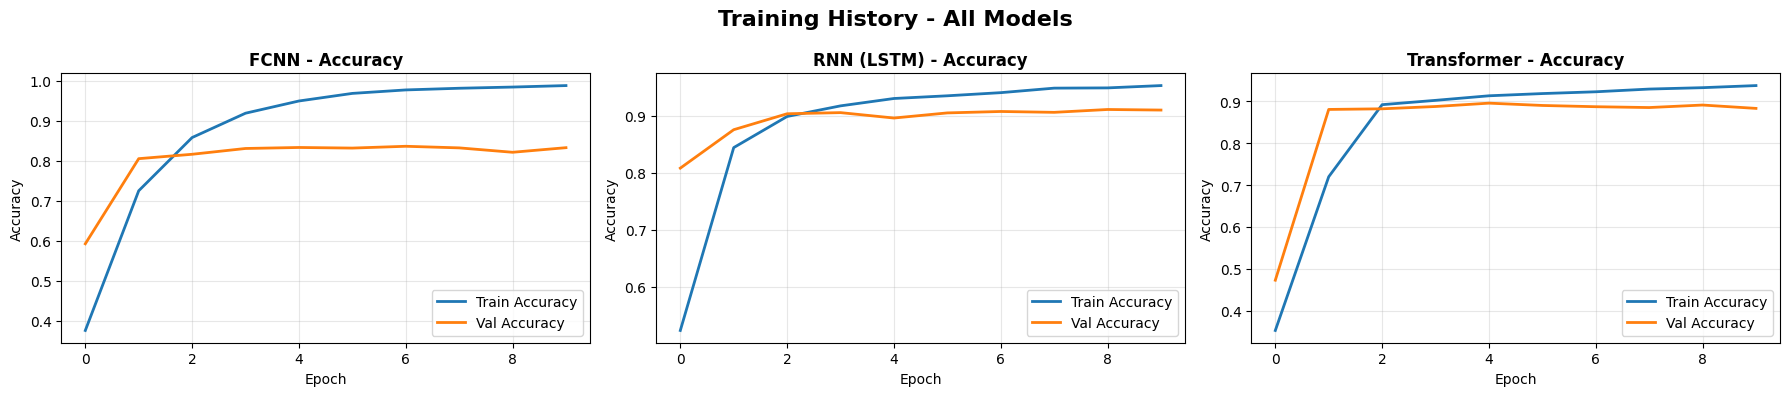


 Training history plots created!
Confusion Matrices


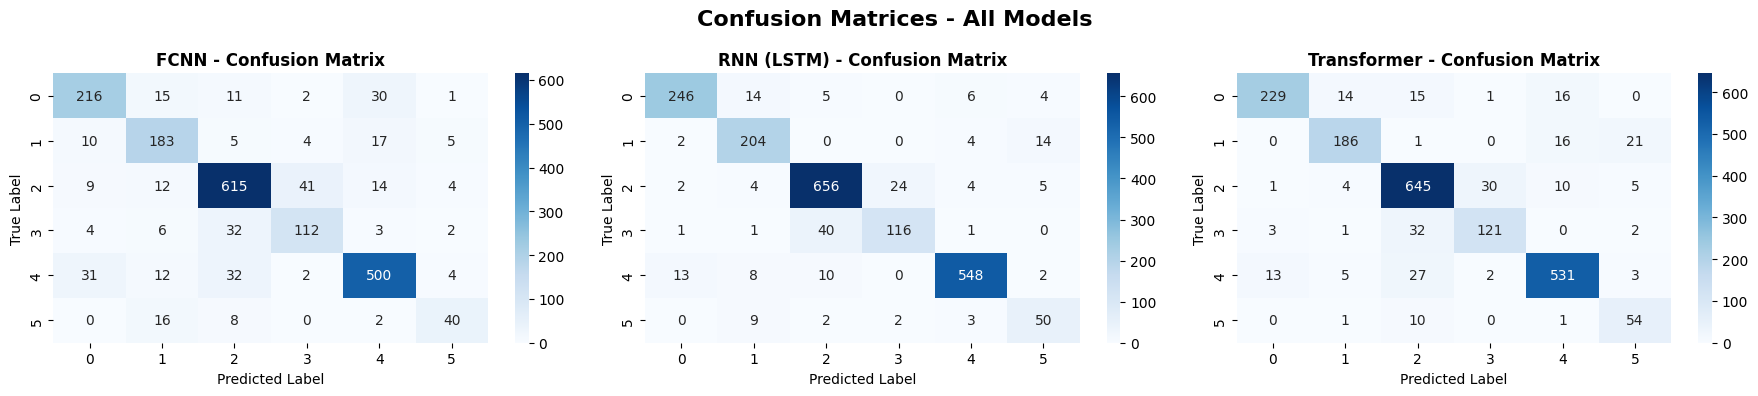


 Confusion matrices created!
VISUALIZATION COMPLETE!


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
print("VISUALIZATIONS - TRAINING HISTORY AND CONFUSION MATRICES")

# Create figure with subplots for training history
if 'fcnn_history' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle('Training History - All Models', fontsize=16, fontweight='bold')

    # FCNN Training History
    axes[0].plot(fcnn_history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(fcnn_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_title('FCNN - Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # RNN Training History
    if 'rnn_history' in locals():
        axes[1].plot(rnn_history.history['accuracy'], label='Train Accuracy', linewidth=2)
        axes[1].plot(rnn_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
        axes[1].set_title('RNN (LSTM) - Accuracy', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    # Transformer Training History
    if 'transformer_history' in locals():
        axes[2].plot(transformer_history.history['accuracy'], label='Train Accuracy', linewidth=2)
        axes[2].plot(transformer_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
        axes[2].set_title('Transformer - Accuracy', fontsize=12, fontweight='bold')
        axes[2].set_ylabel('Accuracy')
        axes[2].set_xlabel('Epoch')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("\n Training history plots created!")
else:
    print("\n Training histories not found. Models need to be trained first.")

# Generate Confusion Matrices if data and predictions are available
if len(X_test_padded) > 0 and 'fcnn_model' in locals():
    print("Confusion Matrices")

    # Get predictions
    fcnn_pred = np.argmax(fcnn_model.predict(X_test_padded, verbose=0), axis=1)
    rnn_pred = np.argmax(rnn_model.predict(X_test_padded, verbose=0), axis=1) if 'rnn_model' in locals() else fcnn_pred
    trans_pred = np.argmax(transformer_model.predict(X_test_padded, verbose=0), axis=1) if 'transformer_model' in locals() else fcnn_pred

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')

    models_info = [
        ('FCNN', fcnn_pred, axes[0]),
        ('RNN (LSTM)', rnn_pred, axes[1]),
        ('Transformer', trans_pred, axes[2])
    ]

    for model_name, predictions, ax in models_info:
        cm = confusion_matrix(y_test_encoded, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True)
        ax.set_title(f'{model_name} - Confusion Matrix', fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()
    print("\n Confusion matrices created!")
else:
    print("\nTest data not available for confusion matrices.")

print("VISUALIZATION COMPLETE!")
